# Homework 2: A/B Hypothesis Testing and Regression

## Due Tuesday, May 29, start of class

### Jake Pitkin

## Part 1 : A/B Hypothesis Testing

Null hypothesis: Ad A and ad B are the same. That is a_prob - b_prob = 0.

In [108]:
import scipy as sc
from scipy.stats import norm

a_views = 1000
a_clicks = 500
a_prob = a_clicks/a_views

b_views = 1000
b_clicks = 550
b_prob = b_clicks/b_views

p_hat = (a_clicks + b_clicks)/(a_views + b_views)
q_hat = 1 - p_hat
print("p_hat:", p_hat)
print("q_hat:", q_hat)

z = (a_prob - b_prob) / sc.sqrt(p_hat*q_hat*(1/a_views + 1/b_views))
print("Z:", z)

p_value = 1 - norm.cdf(z)
print("p-value:", p_value)

if p_value < 0.01 or p_value > 0.99:
    print("Null hypothesis rejected with 1% significance level.")
if p_value < 0.05 or p_value > 0.95:
    print("Null hypothesis rejected with 5% significance level.")

p_hat: 0.525
q_hat: 0.475
Z: -2.2388683142
p-value: 0.98741775715
Null hypothesis rejected with 5% significance level.


## Part 2: Regression of real estate data

### Task 1: Import the data

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

real_estate_one = pd.read_csv("realEstate1.csv", sep=',')
real_estate_two = pd.read_csv("realEstate2.csv", sep=',')
df = pd.concat([real_estate_one, real_estate_two], ignore_index=True)

### Task 2: Clean the data

In [201]:
# Remove houses that don't have a list price between $200,000 and $1,000,000
df = df.drop(df[(df['LstPrice'] <= 200000) | (df['LstPrice'] >= 1000000)].index)

# Only keep attributes we are interested in
df = df[['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 
         'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']].copy()

# Correct the data types for the attributes we are interested in
df['TotSqf'] = df['TotSqf'].str.replace(',','').astype(int)

# Add numerical value for Property Type category
# 1 for a Single Family home and 0 otherwise
df['Prop_Type_num'] = 0
for index, row in df.iterrows():
    if  df.loc[index,'PropType'] == "Single Family":
        df.loc[index,'Prop_Type_num'] = 1

# Drop listing with Longitude of 0
df = df.drop(df[df['Longitude'] == 0.0].index)

# Drop listings with unreasonably large Taxes
df = df.drop(df[df['Taxes'] > 90000].index)

### Task 3: Exploratory data analysis

The dataset contains 257 elements.
It contains 16 different variables.


AttributeError: 'numpy.ndarray' object has no attribute 'remove'

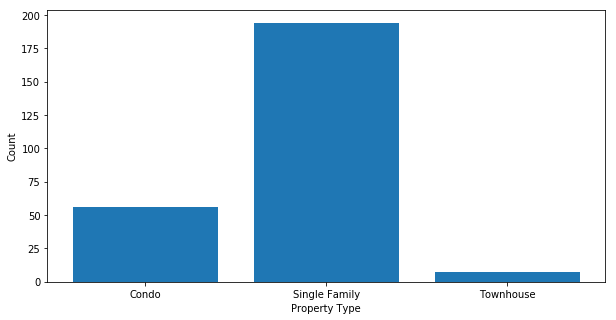

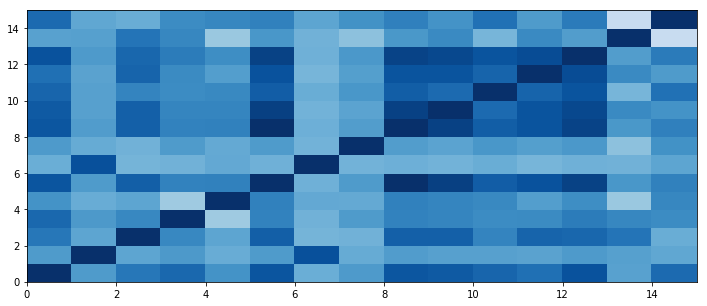

In [270]:
# Description of the dataset
print("The dataset contains {} elements.".format(len(df)))
print("It contains {} different variables.".format(len(df.columns)))

%matplotlib inline

# Bar chart of the different property types
plt.figure(figsize=(10, 5))
plt.xlabel("Property Type")
plt.ylabel("Count")
plt.bar(["Single Family", "Townhouse", "Condo"], [counts["Single Family"], counts["Townhouse"], counts["Condo"]]);

plt.figure(figsize=(12, 5))
heatmap = plt.pcolor(df.corr(), cmap=plt.cm.Blues, vmin=-1, vmax=1)
labels = np.delete(df.columns.values, np.argwhere(df.columns.values == "PropType"))
plt.xticks(np.arange(0.5, 15, step=1), df.columns.values.remove('PropType'), rotation=270)
plt.yticks(np.arange(0.5, 15, step=1), df.columns.values)
plt.colorbar(heatmap)
plt.show()